In [1]:
import sys
import math
from collections import defaultdict

import uproot
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

In [2]:
def ratio_err(num, den, num_err, den_err):
    n, d, n_e, d_e = num, den, num_err, den_err
    return np.array([
        n[i] / d[i] * math.sqrt((n_e[i] / n[i])**2 + (d_e[i] / d[i])**2)
        for i in range(len(num))
    ])


def selection(sample):
    nslice = sample.array("nslice") == 1
    return nslice


pdg_labels = {
    2212: "$p$",
    13: "$\mu$",
    11: "$e$",
    211: "$\pi$",
    2112: "$n$",
    22: "$\gamma$",
    321: "$K$",
    0: "Overlay cosmic"
}

In [3]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open(
    "root_files/prodgenie_bnb_nu_uboone_overlay_mcc9_postCSU_v08_00_00_12_run1_reco2.root"
)[fold][tree]
nue = uproot.open(
    "root_files/prodgenie_bnb_intrinsic_nue_uboone_overlay_mcc9_TESTv12_C1_reco2.root"
)[fold][tree]
data = uproot.open(
    "root_files/data_bnb_optfilter_C1_5e19_goodruns_v08_00_00_12_reco2.root"
)[fold][tree]
ext = uproot.open(
    "root_files/data_extbnb_mcc9.0_v08_00_00_12_run1_reco2.root")[fold][tree]

samples = {"mc": mc, "nue": nue, "data": data, "ext": ext}
weights = {"mc": 0.05425, "nue": 0.00091, "ext": 0.27763}

In [62]:
def plot_variable_pdg(samples, weights, variable, title, **plot_options):
    nu_pdg = samples["mc"].array("nu_pdg") != 12
    selected = selection(samples["mc"]) & nu_pdg

    if "trk" in variable:
        pfp_id_variable = "trk_pfp_id"
    else:
        pfp_id_variable = "shr_pfp_id"

    backtracked_pdg = samples["mc"].array("backtracked_pdg")[selected]
    pfp_id = samples["mc"].array(pfp_id_variable)[selected]
    plotted_variable = samples["mc"].array(variable)[selected]
    pfp_id = np.subtract(pfp_id, 1)
    plotted_variable = plotted_variable.flatten()

    pfp_pdg = np.array(
        [pdg[pfp_id] for pdg, pfp_id in zip(backtracked_pdg, pfp_id)])

    pfp_pdg = np.hstack(pfp_pdg)

    var_dict = defaultdict(list)
    weight_dict = defaultdict(list)
    for k, v in zip(pfp_pdg, plotted_variable):
        var_dict[abs(k)].append(v)
        weight_dict[abs(k)].append(weights["mc"])

    selected_nue = selection(samples["nue"])

    nue_backtracked_pdg = samples["nue"].array("backtracked_pdg")[selected_nue]
    nue_pfp_id = samples["nue"].array(pfp_id_variable)[selected_nue]
    nue_plotted_variable = samples["nue"].array(variable)[selected_nue]
    nue_pfp_id = np.subtract(nue_pfp_id, 1)
    nue_plotted_variable = nue_plotted_variable.flatten()

    nue_pfp_pdg = np.array(
        [pdg[pfp_id] for pdg, pfp_id in zip(nue_backtracked_pdg, nue_pfp_id)])

    nue_pfp_pdg = np.hstack(nue_pfp_pdg)

    for k, v in zip(nue_pfp_pdg, nue_plotted_variable):
        var_dict[abs(k)].append(v)
        weight_dict[abs(k)].append(weights["nue"])

    selected_data = selection(samples["data"])
    data_plotted_variable = samples["data"].array(variable)[selected_data]
    data_plotted_variable = data_plotted_variable.flatten()

    selected_ext = selection(samples["ext"])
    ext_plotted_variable = samples["ext"].array(variable)[selected_ext]
    ext_plotted_variable = ext_plotted_variable.flatten()

    fig = plt.figure(figsize=(8, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    total = sum(sum(weight_dict[pdg]) for pdg in var_dict)
    total += sum([weights["ext"]] * len(ext_plotted_variable))
    total_array = np.concatenate(list(var_dict.values()))
    total_weight = np.concatenate(list(weight_dict.values()))

    total_hist, total_bins = np.histogram(
        total_array, **plot_options, weights=total_weight)

    labels = [
        "%s: %.1f%%" % (pdg_labels[pdg], sum(weight_dict[pdg]) / total * 100)
        for pdg in var_dict.keys()
    ]

    ax1.hist(
        var_dict.values(),
        **plot_options,
        weights=list(weight_dict.values()),
        stacked=True,
        label=labels)

    ext_weight = [weights["ext"]] * len(ext_plotted_variable)
    n_ext, ext_bins, patches = ax1.hist(
        ext_plotted_variable,
        **plot_options,
        weights=ext_weight,
        bottom=total_hist,
        label="EXT: %.1f%%" %
        (sum([weights["ext"]] * len(ext_plotted_variable)) / total * 100),
        hatch="//",
        color="white")

    total_array = np.concatenate([total_array, ext_plotted_variable])
    total_weight = np.concatenate([total_weight, ext_weight])

    n_tot, bin_edges, patches = ax1.hist(
        total_array,
        **plot_options,
        weights=total_weight,
        histtype="step",
        edgecolor="black")

    bincenters = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mc_uncertainties, bins = np.histogram(plotted_variable, **plot_options)
    err_mc = np.array(
        [n * weights["mc"] * weights["mc"] for n in mc_uncertainties])

    nue_uncertainties, bins = np.histogram(nue_plotted_variable,
                                           **plot_options)
    err_nue = np.array(
        [n * weights["nue"] * weights["nue"] for n in nue_uncertainties])

    err_ext = np.array([n * weights["ext"] * weights["ext"] for n in n_ext])

    exp_err = np.sqrt(err_mc + err_ext + err_nue)
    bin_size = [(bin_edges[i + 1] - bin_edges[i]) / 2
                for i in range(len(bin_edges) - 1)]
    ax1.bar(bincenters, n_tot, width=0, yerr=exp_err)

    n_data, bins = np.histogram(data_plotted_variable, **plot_options)
    data_err = np.sqrt(n_data)
    ax1.errorbar(
        bincenters,
        n_data,
        xerr=bin_size,
        yerr=data_err,
        fmt='ko',
        label="BNB")

    leg = ax1.legend(
        frameon=False, ncol=2, title=r'MicroBooNE Preliminary 4.5e19 POT')
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(), fontweight='bold')

    ax1.set_xlim(plot_options["range"][0], plot_options["range"][1])
    ax1.set_xlabel("")
    xrange = plot_options["range"][1] - plot_options["range"][0]
    unit = title[title.find("[") +
                 1:title.find("]")] if "[" and "]" in title else ""
    ax1.set_ylabel(
        "N. Entries / %g %s" % (xrange / plot_options["bins"], unit))
    ax1.set_xticks([])

    bin_size = [(bin_edges[i + 1] - bin_edges[i]) / 2
                for i in range(len(bin_edges) - 1)]
    ratio_error = ratio_err(n_data, n_tot, data_err, exp_err)
    ax2.errorbar(
        bincenters, n_data / n_tot, xerr=bin_size, yerr=ratio_error, fmt="ko")

    ratio_error_mc = ratio_err(n_tot, n_tot, exp_err, exp_err)
    ratio_error_mc = np.insert(ratio_error_mc, 0, ratio_error_mc[0])
    ax2.fill_between(
        bin_edges,
        1 - ratio_error_mc,
        ratio_error_mc + 1,
        step="pre",
        color="grey",
        alpha=0.5)

    ax2.set_xlabel(title)
    ax2.set_xlim(plot_options["range"][0], plot_options["range"][1])
    ax2.set_ylim(0.5, 1.5)
    ax2.set_ylabel("BNB / (MC+EXT)")
    ax2.axhline(1, linestyle="--", color="k")

    fig.tight_layout()
    fig.savefig("plots/%s_pdg.pdf" % variable)

    return fig, ax1, ax2


def plot_variable_samples(samples, weights, variable, title, **plot_options):
    nu_pdg = samples["mc"].array("nu_pdg") != 12

    selected_mc = selection(samples["mc"]) & nu_pdg
    mc_plotted_variable = samples["mc"].array(variable)[selected_mc]
    mc_weight = [weights["mc"]] * len(mc_plotted_variable)

    selected_nue = selection(samples["nue"])
    nue_plotted_variable = samples["nue"].array(variable)[selected_nue]
    nue_weight = [weights["nue"]] * len(nue_plotted_variable)

    selected_data = selection(samples["data"])
    data_plotted_variable = samples["data"].array(variable)[selected_data]

    selected_ext = selection(samples["ext"])
    ext_plotted_variable = samples["ext"].array(variable)[selected_ext]
    ext_weight = [weights["ext"]] * len(ext_plotted_variable)

    fig = plt.figure(figsize=(8, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    n_mc, mc_bins, patches = ax1.hist(
        mc_plotted_variable,
        **plot_options,
        weights=mc_weight,
        label="BNB overlay: %g events" % sum(mc_weight))

    n_nue, nue_bins, patches = ax1.hist(
        nue_plotted_variable,
        **plot_options,
        bottom=n_mc,
        weights=nue_weight,
        label=r"$\nu_{e}$ overlay: %g events" % sum(nue_weight))

    n_ext, ext_bins, patches = ax1.hist(
        ext_plotted_variable,
        **plot_options,
        bottom=n_mc + n_nue,
        weights=ext_weight,
        label="EXT: %g events" % sum(ext_weight),
        hatch="//",
        color="white")

    total_variable = np.concatenate(
        [mc_plotted_variable, nue_plotted_variable, ext_plotted_variable])
    total_weight = np.concatenate([mc_weight, nue_weight, ext_weight])

    n_tot, tot_bins, pateches = ax1.hist(
        total_variable,
        **plot_options,
        weights=total_weight,
        histtype="step",
        edgecolor="black")

    err_mc = np.array([n * weights["mc"] * weights["mc"] for n in n_mc])
    err_nue = np.array([n * weights["nue"] * weights["nue"] for n in n_nue])
    err_ext = np.array([n * weights["ext"] * weights["ext"] for n in n_ext])
    tot_uncertainties = np.sqrt(err_mc + err_ext + err_nue)

    bincenters = 0.5 * (tot_bins[1:] + tot_bins[:-1])
    exp_err = tot_uncertainties
    bin_size = [(tot_bins[i + 1] - tot_bins[i]) / 2
                for i in range(len(tot_bins) - 1)]
    ax1.bar(bincenters, n_tot, width=0, yerr=exp_err)

    n_data, bins = np.histogram(data_plotted_variable, **plot_options)
    data_err = np.sqrt(n_data)
    ax1.errorbar(
        bincenters,
        n_data,
        xerr=bin_size,
        yerr=data_err,
        fmt='ko',
        label="BNB: %i events" % sum(n_data))
    leg = ax1.legend(frameon=False, title=r'MicroBooNE Preliminary 4.5e19 POT')
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(), fontweight='bold')

    unit = title[title.find("[") +
                 1:title.find("]")] if "[" and "]" in title else ""
    xrange = plot_options["range"][1] - plot_options["range"][0]
    print(xrange)
    ax1.set_ylabel(
        "N. Entries / %g %s" % (xrange / plot_options["bins"], unit))
    ax1.set_xticks([])
    ax1.set_xlim(plot_options["range"][0], plot_options["range"][1])
    bin_size = [(bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)]
    ratio_error = ratio_err(n_data, n_tot, data_err, exp_err)
    ax2.errorbar(
        bincenters, n_data / n_tot, xerr=bin_size, yerr=ratio_error, fmt="ko")

    ratio_error_mc = ratio_err(n_tot, n_tot, exp_err, exp_err)
    ratio_error_mc = np.insert(ratio_error_mc, 0, ratio_error_mc[0])
    ax2.fill_between(
        bins,
        1 - ratio_error_mc,
        ratio_error_mc + 1,
        step="pre",
        color="grey",
        alpha=0.5)

    ax2.set_xlabel(title)
    ax2.set_xlim(plot_options["range"][0], plot_options["range"][1])
    ax2.set_ylim(0.5, 1.5)
    ax2.set_ylabel("BNB / (MC+EXT)")
    ax2.axhline(1, linestyle="--", color="k")

    fig.tight_layout()
    fig.savefig("plots/%s_samples.pdf" % variable)

    return fig, ax1, ax2

10
10


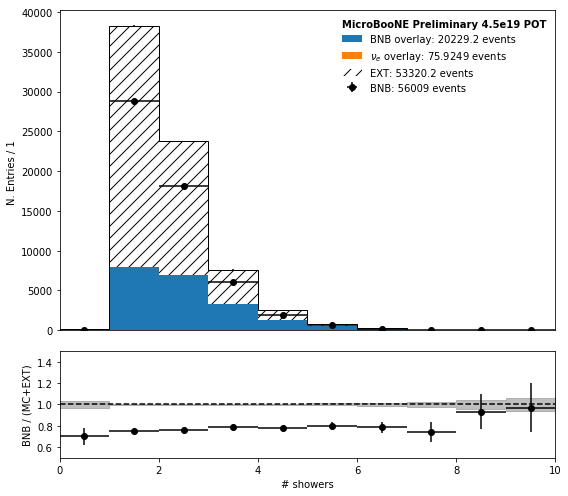

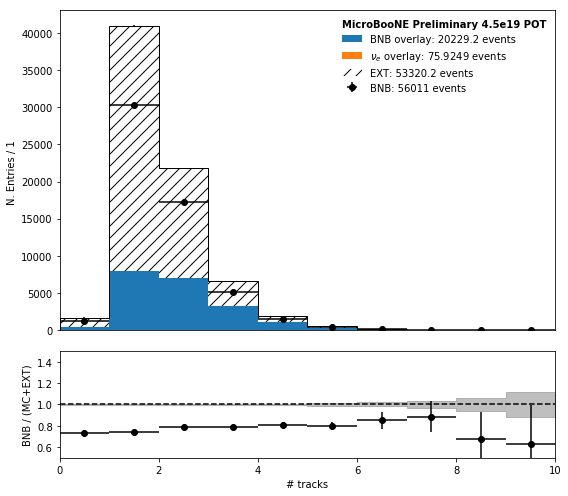

In [63]:
# fig_track_start_x = plot_variable_pdg(samples, weights, "trk_start_x", "Track start x [cm]", bins=40, range=(0,256))
fig_n_showers = plot_variable_samples(
    samples, weights, "n_showers", "# showers", bins=10, range=(0, 10))
fig_n_tracks = plot_variable_samples(
    samples, weights, "_ntrack", "# tracks", bins=10, range=(0, 10))